In [1]:
# importing the libraries
import requests
import pandas as pd
import re
import string

from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from operator import itemgetter
from datetime import datetime
from matplotlib.pyplot import plot as plt

### Let´s request the access of Indeed website, looking for Data Analyst

In [2]:
def request_URL(URL):
    #show the website
    #print(URL)
    
    #conducting a request of the stated URL above:
    page = requests.get(URL)

    #specifying a desired format of 'page' using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

In [3]:
word = 'data+analyst'
URL = 'https://ie.indeed.com/jobs?as_and=' + word + '&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=100&l=Dublin&fromage=any&limit=1000&sort=date&psf=advsrch&from=advancedsearch'
soup = request_URL(URL)

### Let´s get the identification of each job to check the full description of the job

In [4]:
# get the identification of each job
jobs = []
keys = [div.get('data-jk') for div in soup.findAll('div', attrs={'data-tn-component': 'organicJob'})]

### Let´s request the access of each specific information

In [5]:
# For each specific job(key) get the request
job_information = []
for job in keys:
    URL_job = 'https://ie.indeed.com/viewjob?jk=' + job
    soup_job = request_URL(URL_job)
   
    company = soup_job.find(name='div', attrs={'class':'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).get_text()
    title = soup_job.find(name='h1', attrs={'class':'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'}).get_text()
    job_description = soup_job.find('div', attrs={'id': 'jobDescriptionText'}).get_text()
    date = datetime.now()    
    
    job_information.append((date, company, title, job_description, URL_job))

In [6]:
# using set_option to show all text - not truncated
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(job_information,columns=['date','company','title','full description', 'link'])

### Let´s create a file with the information about the jobs selected

In [12]:
df.to_csv('Files/jobs_indeed.csv', mode='a', encoding='utf-8')

### Now we need to clean up the text to get rid of space, blank lines and punctuation

In [8]:
# cleaning using regex
def clean_text(text):
    text = re.sub(r'[\n]',' ',text) # delete \n
    text = re.sub('\s+',' ',text) # delete spaces
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text) # delete all punctuation
    text = re.sub('—','',text)
    text = re.sub('’s','',text)
 
    return text

# cleaning the column summary using regex
df['full description'] = df['full description'].apply(lambda x: clean_text(x))

### Now we will check the frequency of the words and to eliminate the stopwords

In [9]:
blob = TextBlob(str(df['full description']))

# word_counts is a dictionary, so we use items and get rid off the stop words
items = blob.word_counts.items() 

stop_words = stopwords.words('english')
items = [item for item in items if item[0] not in stop_words]

# now we will create a df with the frequency of the words
df_word_count = pd.DataFrame(items, columns=['word','count'])
df_word_count.sort_values(by='count',ascending=False,inplace=True)

<AxesSubplot:title={'center':'Job Indeed searching by "data+analyst"\nTop 20'}, xlabel='word'>

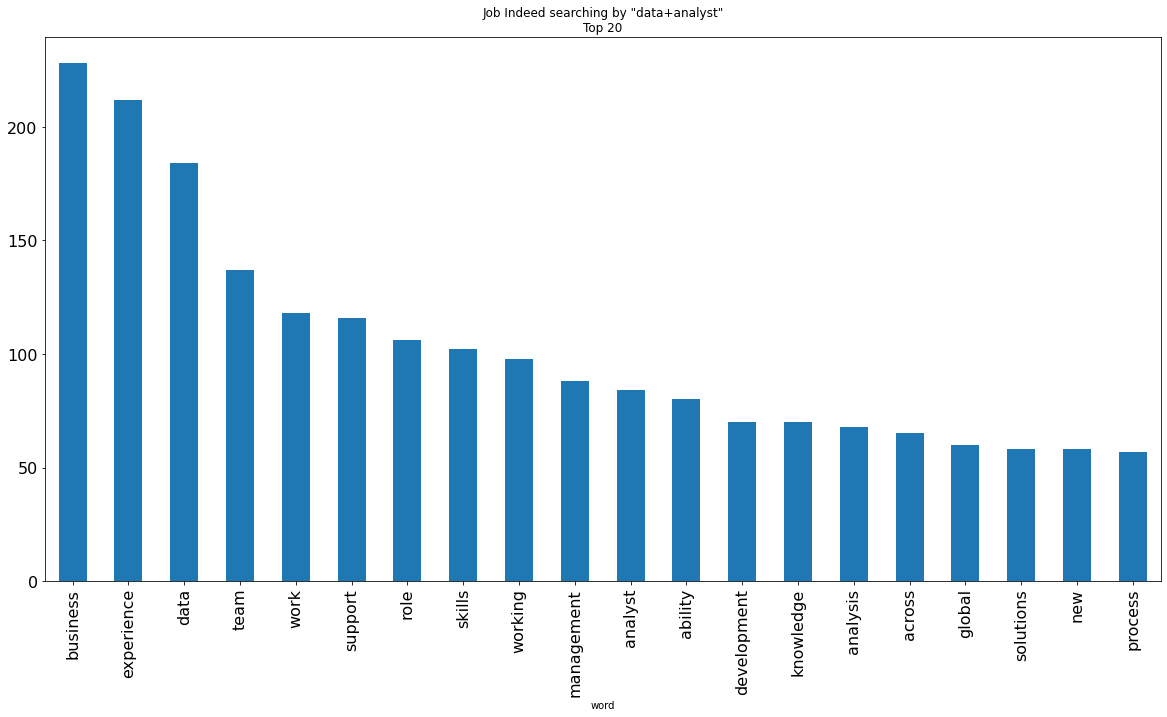

In [10]:
# plot the top20 words
df_top = df_word_count.head(20)
df_top.plot.bar(x='word', y='count',legend=False,figsize=(20,10),title=f'Job Indeed searching by "{word}"\nTop 20',fontsize=16)

In [11]:
skills = ['python','sql','tableau','excel', 'aws','git','scrum','linux','devops']
for s in skills:
    print(s,end='->')
    print(len(df['company'][df['full description'].str.lower().str.contains(s)]))

python->7
sql->20
tableau->8
excel->32
aws->5
git->8
scrum->2
linux->3
devops->1
